In [1]:
%load_ext autoreload
%autoreload 2
%load_ext tensorboard

In [2]:
# !pip install -r requirements.txt

# Data: CelebA

## Dataset

In [3]:
from src.modules.classification_data_model import ClassificationDataset, Classification_Model
from src.tools.dataset_tools import get_dataset_filename_map, dataset_gdrive_download, get_labels, save_images_in_folders
import config_celeba
import os
import numpy as np

# download celeba dataset
dataset_gdrive_download(config = config_celeba)

# get labels map
# save_images_in_folders(config = config_celeba)
labels_map = get_labels(config = config_celeba, in_folders = False)

print('Number of class in label map', len(list(labels_map.keys())) )

print('\ntesting dataset')

# num_classes = 10177
num_classes=100

dataset = ClassificationDataset(labels_map, num_classes=list(range(num_classes)))
print('nb samples', len(dataset))
print('nb classes in dataloader', dataset.nb_classes())

Dataset already downloaded
Labels already downloaded
Number of class in label map 10177

testing dataset
nb samples 2234
nb classes in dataloader 100


 Train dataset ----------------------------




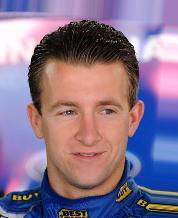

label 0
shape (178, 218)




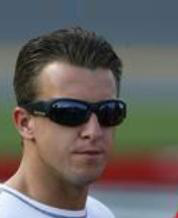

label 0
shape (178, 218)


In [4]:
#image from train dataset
print(" Train dataset ----------------------------")
for i, (image, label) in enumerate(dataset):
    print("\n")
    display(image)
    print("label",label)
    print('shape', image.size)
    if i==1:
        break


## Dataloader with custom sampler

In [5]:
import multiprocessing as mp
from src.modules.classification_data_model import DATASETS

num_classes_iter = 4
batch_size = 16
dataloader = Classification_Model(name=DATASETS.CELEBA, nb_classes=num_classes, class_split=True, batch_size = batch_size,
                               num_classes_iter=num_classes_iter, splitting_points=(0.10, 0.10),  
                               input_shape = (3, 256, 256), num_workers = mp.cpu_count(), in_folders=False)

dataloader.setup()

train_loader = dataloader.train_dataloader()
val_loader = dataloader.val_dataloader()
test_loader = dataloader.test_dataloader()

print("Number of train batches", len(train_loader))
print("Number of valid batches", len(val_loader))
print("Number of test batches", len(test_loader))

train classes 0 90
test classes 90 100
split size 1790 198 246
Number of train batches 112
Number of valid batches 7
Number of test batches 8


max value 1.0
min value 0.0
shape torch.Size([16, 3, 256, 256])
[tensor(5), tensor(5), tensor(5), tensor(5)]
[tensor(62), tensor(62), tensor(62), tensor(62)]
[tensor(29), tensor(29), tensor(29), tensor(29)]
[tensor(69), tensor(69), tensor(69), tensor(69)]


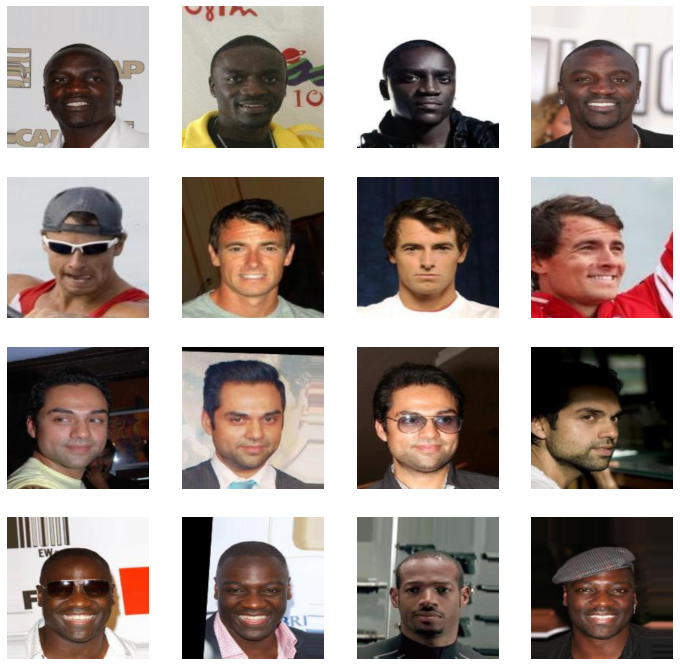

In [6]:
#Dataloader samples
from src.tools.visualization_tools import visualize_torch
import torch

n_row = num_classes_iter
n_cols = int(batch_size/num_classes_iter)

for i, (im, label) in enumerate(train_loader):
    print('max value', torch.max(im).item())
    print('min value', torch.min(im).item())
    print('shape', im.shape)
    visualize_torch(im, n_cols=n_cols, n_rows=n_row)
    for j in range(0, len(label), 4):
        print(list(label[j:j+4]))
    
    if i == 0:
        break

max value 1.0
min value 0.0
shape torch.Size([32, 3, 256, 256])
[tensor(37), tensor(37), tensor(37), tensor(37)]
[tensor(17), tensor(17), tensor(17), tensor(17)]
[tensor(28), tensor(28), tensor(28), tensor(28)]
[tensor(33), tensor(33), tensor(33), tensor(33)]
[tensor(11), tensor(11), tensor(11), tensor(11)]
[tensor(7), tensor(7), tensor(7), tensor(7)]
[tensor(84), tensor(84), tensor(84), tensor(84)]
[tensor(32), tensor(32), tensor(32), tensor(32)]


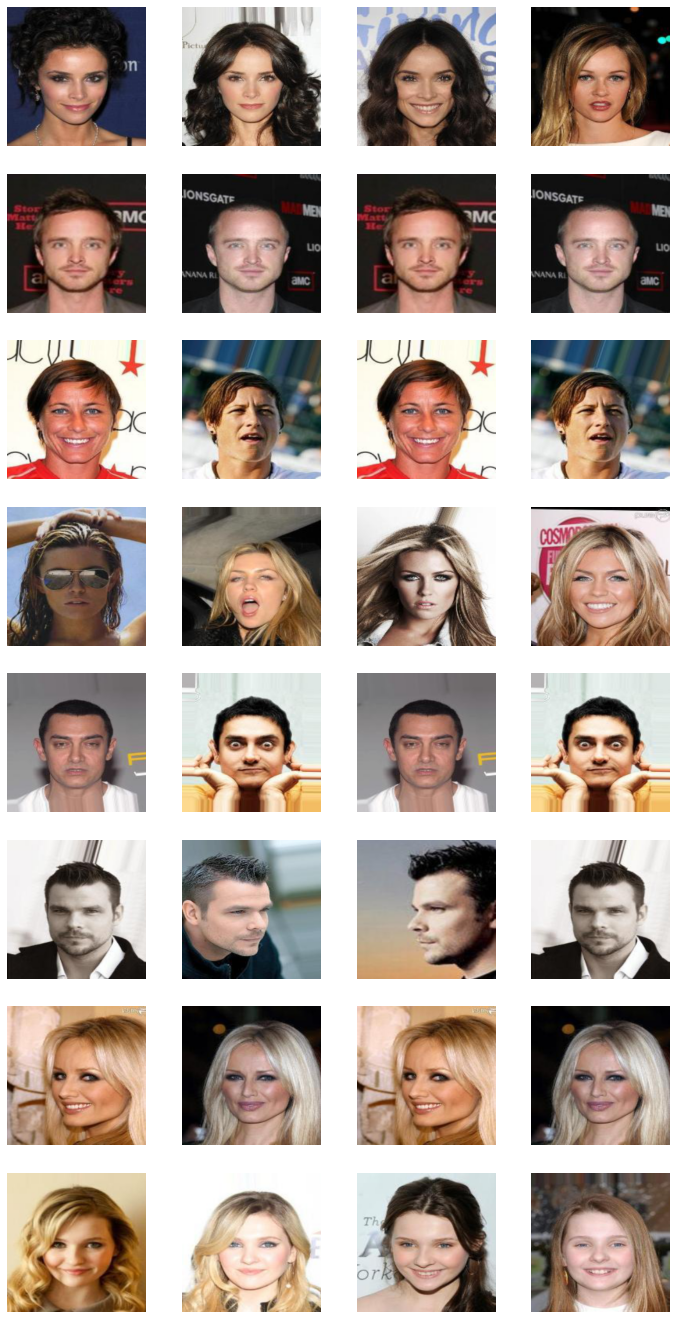

In [7]:
for i, (im, label) in enumerate(val_loader):
    print('max value', torch.max(im).item())
    print('min value', torch.min(im).item())
    print('shape', im.shape)
    visualize_torch(im, n_cols=n_cols, n_rows=int(n_row*2))
    for j in range(0, len(label), 4):
        print(list(label[j:j+4]))
    
    if i == 0:
        break

max value 1.0
min value 0.0
shape torch.Size([32, 3, 256, 256])
[tensor(98), tensor(98), tensor(98), tensor(98)]
[tensor(94), tensor(94), tensor(94), tensor(94)]
[tensor(98), tensor(98), tensor(98), tensor(98)]
[tensor(97), tensor(97), tensor(97), tensor(97)]
[tensor(99), tensor(99), tensor(99), tensor(99)]
[tensor(98), tensor(98), tensor(98), tensor(98)]
[tensor(95), tensor(95), tensor(95), tensor(95)]
[tensor(92), tensor(92), tensor(92), tensor(92)]


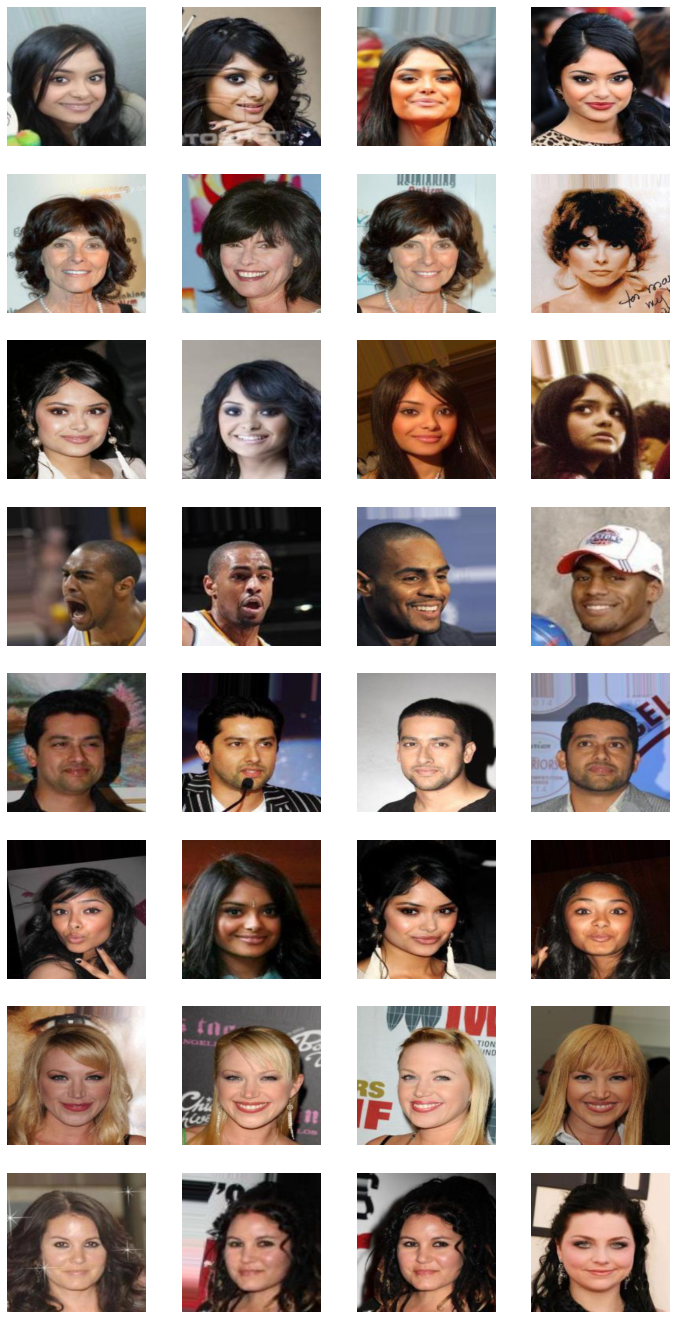

In [8]:
for i, (im, label) in enumerate(test_loader):
    print('max value', torch.max(im).item())
    print('min value', torch.min(im).item())
    print('shape', im.shape)
    visualize_torch(im, n_cols=n_cols, n_rows=int(n_row*2))
    for j in range(0, len(label), 4):
        print(list(label[j:j+4]))
    
    if i == 0:
        break

# Hyperparameter Tunning

In [9]:
do_tune = False
if do_tune:
    import optuna
    from src.hyper_tune import tune

    study = optuna.create_study( direction="maximize" )
    study.optimize( tune.objective, n_trials=20)

    print( "Number of finished trials: {}".format( len(study.trials) ) )

    print( "Best trial:" )
    trial = study.best_trial

    print( "  Value: {}".format( trial.value ) )

    print( "  Params: " )
    for key, value in trial.params.items():
      print( "    {}: {}".format( key, value ) )

# Training the model

## Choosing the model

In [10]:
from src.model.CustomModelGroupLoss import Siamese_Group, CNN_MODEL_GROUP
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from torch import nn
from torchsummary import summary

# cnn_model = CNN_MODEL_GROUP.MyCNN
cnn_model = CNN_MODEL_GROUP.BN_INCEPTION

if cnn_model == CNN_MODEL_GROUP.MyCNN:
    model_hparams = {
        "lr": 0.001,
        "weight_decay":1e-5,
        "filter_channels": 4,
        "filter_size": 3,
        "dropout": 0.00,
        "n_hidden1": 4096,
        "n_hidden2": 2048,
        'temperature': 10,
        'num_labeled_points_class': 2,
    }
    
    scheduler_params = {
        "step_size": 5,
        "gamma": 0.5,
    }
elif cnn_model == CNN_MODEL_GROUP.BN_INCEPTION:
    model_hparams = {
        "lr": 0.0001602403,
        "weight_decay":8.465428e-5,
        'temperature': 12,
        'num_labeled_points_class': 2
    }
    
    scheduler_params = {
        "step_size": 10,
        "gamma": 0.5,
    }

# scheduler_params = None

num_classes = 10177
# num_classes = 1000

model = Siamese_Group(hparams=model_hparams, 
                cnn_model = cnn_model, 
                scheduler_params = scheduler_params,
                nb_classes = num_classes,
                finetune=False, 
                weights_path=None,
                     )

if torch.cuda.is_available():
    model.to('cuda')
print(summary(model,[ (3, model.input_size, model.input_size)]))
model.cpu()

print("Model input size", model.input_size)

Layers to update
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,472
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,160
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8          [-1, 192, 56, 56]         110,784
       BatchNorm2d-9          [-1, 192, 56, 56]             384
             ReLU-10          [-1, 192, 56, 56]               0
        MaxPool2d-11          [-1, 192, 28, 28]               0
           Conv2d-12           [-1, 64, 28, 28]          12,352
      BatchNorm2d-13           [-1, 64, 28, 28]             128
             ReLU-14  

## Defining the Dataloader

In [11]:
print('len dataset', len(dataset))

load_celeb = True

if load_celeb:
    num_classes_iter = 24
    num_elem_class = 6

    batch_size = num_classes_iter*num_elem_class


    dataloader = Classification_Model(name=DATASETS.CELEBA, 
                                   nb_classes=num_classes, 
                                   class_split=True, 
                                   batch_size=batch_size, 
                                   num_classes_iter=num_classes_iter, 
                                   splitting_points=(0.20, 0.20), 
                                   input_shape = (3, model.input_size, model.input_size),
                                   num_workers = mp.cpu_count(),
                                   finetune = False)

    dataloader.setup()

    train_loader = dataloader.train_dataloader()
    val_loader = dataloader.val_dataloader()
    test_loader = dataloader.test_dataloader()

    print("Number of train batches", len(train_loader))
    print("Number of valid batches", len(val_loader))
    print("Number of test batches", len(test_loader))

    for i, batch in enumerate(train_loader):
        x, y = batch
        print(x.shape)
        break

len dataset 2234
train classes 0 8141
test classes 8141 10177
split size 131269 32817 38513
Number of train batches 2735
Number of valid batches 342
Number of test batches 402
torch.Size([48, 3, 224, 224])


In [12]:
# %tensorboard --logdir data/tb_group_logs/

## Train Custom Model

Please get the pretrained weights from https://drive.google.com/drive/folders/1tOCWXoAjKkIAvIECfQaKnZEIhl1z2ZGh?usp=sharing and place them in data/net/. for training the neural network

In [13]:
exp_name = 'group_loss_tuned_2of24'

early_stop_callback = pl.callbacks.EarlyStopping(
    monitor='val_R%_@1',
    patience=10,
    strict=False,
    verbose=False,
    mode='max'
)

checkpoint_callback = pl.callbacks.ModelCheckpoint(
    monitor='val_R%_@1',
    dirpath=f'data/checkpoint/{exp_name}',
    filename='Group-{epoch:02d}-{val_loss:.2f}-{val_R%_@1:.2f}',
    save_top_k=10,
    mode='max',
)

lr_monitor = pl.callbacks.LearningRateMonitor()

trainer_params = {
    "check_val_every_n_epoch": 1, 
    "callbacks": [
        early_stop_callback,
        checkpoint_callback,
        lr_monitor,
    ],
    "fast_dev_run": False,
    "max_epochs": 100,
    "gpus":1 if torch.cuda.is_available() else None,
    
}

# logname = 'resnet_BCE'
logger = TensorBoardLogger(os.path.join('data','tb_group_logs'), name=exp_name)

do_train = True

trainer = pl.Trainer(**trainer_params, logger = logger)
if do_train:
    trainer.fit(model, dataloader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Running in fast_dev_run mode: will run a full train, val and test loop using a single batch

  | Name       | Type             | Params
------------------------------------------------
0 | gtg        | GTG              | 0     
1 | criterion  | NLLLoss          | 0     
2 | criterion2 | CrossEntropyLoss | 0     
3 | model      | BnInception      | 20.7 M


# Save/Load Checkpoint

## Manual Save

In [39]:
import os
from src.tools.checkpoint_tools import save_model_txt, load_model_txt

save_checkpoint = False
if save_checkpoint:
    save_dir = os.path.join('data', 'saved', 'inc_last')  
    checkpoint_path = os.path.join(save_dir, 'inc_nll_last.ckpt')
    trainer.save_checkpoint(checkpoint_path)


save_ibm = False
if save_ibm:
    ibm_dir = os.path.join(checkpoint_callback.dirpath, 'ibm')
    if not os.path.exists(ibm_dir):
        os.mkdir(ibm_dir)
        
    save_path = os.path.join(ibm_dir, 'Group-epoch=23-val_loss=2.96.txt')
    save_model_txt(model, save_path)

## Load Checkpoint
Download checkpoints from https://drive.google.com/drive/folders/1puXPrBrquphElXiCDuZSIbSYdRqprxG0?usp=sharing and use the checkpoints from group loss

In [40]:
load_checkpoint = False

if load_checkpoint:
#     checkpoint_path = checkpoint_callback.best_model_path
    checkpoint_path = os.path.join(checkpoint_callback.dirpath, 'Group-epoch=23-val_loss=2.96.ckpt')
    model = model.load_from_checkpoint(checkpoint_path=checkpoint_path)
    
load_ibm = False
if load_ibm:
    load_path = os.path.join(checkpoint_callback.dirpath, 'ibm', 'Group-epoch=23-val_loss=2.96.txt')
    load_model_txt(model, load_path)

Iter 0
Iter 1
Iter 2
Iter 3
Iter 4
Iter 5
Iter 6
Iter 7
Iter 8
Iter 9
Iter 10
Iter 11
Iter 12
Iter 13
Iter 14
Iter 15
Iter 16
Iter 17
Iter 18
Iter 19
Iter 20
Iter 21
Iter 22
Iter 23
Iter 24
Iter 25
Iter 26
Iter 27
Iter 28
Iter 29
Iter 30
Iter 31
Iter 32
Iter 33
Iter 34
Iter 35
Iter 36
Iter 37
Iter 38
Iter 39
Iter 40
Iter 41
Iter 42
Iter 43
Iter 44
Iter 45
Iter 46
Iter 47
Iter 48
Iter 49
Iter 50
Iter 51
Iter 52
Iter 53
Iter 54
Iter 55
Iter 56
Iter 57
Iter 58
Iter 59
Iter 60
Iter 61
Iter 62
Iter 63
Iter 64
Iter 65
Iter 66
Iter 67
Iter 68
Iter 69
Iter 70
Iter 71
Iter 72
Iter 73
Iter 74
Iter 75
Iter 76
Iter 77
Iter 78
Iter 79
Iter 80
Iter 81
Iter 82
Iter 83
Iter 84
Iter 85
Iter 86
Iter 87
Iter 88
Iter 89
Iter 90
Iter 91
Iter 92
Iter 93
Iter 94
Iter 95
Iter 96
Iter 97
Iter 98
Iter 99
Iter 100
Iter 101
Iter 102
Iter 103
Iter 104
Iter 105
Iter 106
Iter 107
Iter 108
Iter 109
Iter 110
Iter 111
Iter 112
Iter 113
Iter 114
Iter 115
Iter 116
Iter 117
Iter 118
Iter 119
Iter 120
Iter 121
Iter 122
Ite

## Retrain from checkpoint

In [16]:
resume_training = False
if resume_training:
    checkpoint_path = checkpoint_callback.best_model_path
    trainer = pl.Trainer(**trainer_params, resume_from_checkpoint=checkpoint_path)
    trainer.fit(model)

# Evaluate Model

## Run validation epoch

In [17]:
if load_celeb:
    trainer.test(model, dataloader.val_dataloader())

### Note: Computational heavy!!!!

In [18]:
calc_all_recall = False
calc_nmi = True

In [19]:
from src.tools import evaluation_tool

if calc_all_recall:
    recall, nmi = evaluation_tool.evaluate(model.to('cuda'), dataloader=dataloader.val_dataloader(), calc_nmi=calc_nmi)
    print('recall', recall.detach())
    if calc_nmi:
        print('nmi', nmi)

## Run test epoch

In [20]:
if load_celeb:
    trainer.test(model, dataloader.test_dataloader())

### Note: Computational heavy!!!!

In [21]:
from src.tools import evaluation_tool

if calc_all_recall:
    recall, nmi = evaluation_tool.evaluate(model, dataloader=dataloader.test_dataloader(), calc_nmi=calc_nmi)
    print('recall', recall)

    if calc_nmi:
        print('nmi', nmi)

# Inference and Visualization

In [22]:
from src.tools.model_tools import get_k_similar_group
from src.tools import evaluation_tool
from src import evaluation
from torch.utils import data
import sklearn

if load_celeb:
    for x, y, indices, distances in get_k_similar_group(model, loader=dataloader.val_dataloader()):
        print(x.shape)
        for img_idx, closest_idx in enumerate(indices[:, 0]):        
            img_matches = torch.stack([ x[int(img_idx)], x[int(closest_idx)] ])
            caption = f'labels_{img_idx}:', y[int(img_idx)].item(), y[int(closest_idx)].item(), 'distance: {:.3f}'.format(distances[img_idx, closest_idx])
            visualize_torch(img_matches, n_cols=2, n_rows=1, caption=caption)
            if int(img_idx) == 5:
                break
        break


In [23]:
from src.tools.model_tools import get_k_similar_group
from src.tools import evaluation_tool
from src import evaluation
from torch.utils import data
import sklearn

if load_celeb:
    for x, y, indices, distances in get_k_similar_group(model, loader=dataloader.test_dataloader()):
        for img_idx, closest_idx in enumerate(indices[:, 0]):        
            img_matches = torch.stack([ x[int(img_idx)], x[int(closest_idx)] ])
            caption = f'labels_{img_idx}:', y[int(img_idx)].item(), y[int(closest_idx)].item(), 'distance: {:.3f}'.format(distances[img_idx, closest_idx])
            visualize_torch(img_matches, n_cols=2, n_rows=1, caption=caption)
            if int(img_idx) == 5:
                break
        break

# Test on LFW Dataset

In [ ]:
from src.tools.dataset_tools import dataset_download_targz
do_download = False
if do_download:
    dataset_download_targz()

## Create Dataloader

In [41]:
# get label map
from src.tools.dataset_tools import get_dataset_filename_map, get_list_of_indices, get_transforms
import config_lfw
from src.tools.combine_sampler import CombineSampler
import torch

num_classes=1680
num_classes_iter = 16
num_elem_class = 6
batch_size = num_classes_iter*num_elem_class

lfw_map = get_dataset_filename_map(config = config_lfw)
dataset = ClassificationDataset(lfw_map, 
                                num_classes=list(range(num_classes)), 
                                map_to_int=True, 
                                offset_y=0)
dataset.set_transform(get_transforms((3, model.input_size, model.input_size), mode = 'test'))

lfw_dataloader = torch.utils.data.DataLoader(dataset,
                                           batch_size=batch_size,
                                           num_workers=mp.cpu_count(),
                                           shuffle=False,
                                           sampler=CombineSampler(
                                                get_list_of_indices(dataset),
                                                num_classes_iter,
                                                num_elem_class),
                                           collate_fn=None,
                                           )
print(len(lfw_dataloader))

96


## Test

In [42]:
trainer.test(model, lfw_dataloader)

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'avg_ce_loss': tensor(13.3459, device='cuda:0'),
 'avg_loss': tensor(15.4340, device='cuda:0'),
 'avg_nll_loss': tensor(2.0880, device='cuda:0'),
 'avg_recall@1': tensor(0.9162)}
--------------------------------------------------------------------------------



[{'avg_loss': 15.433974266052246,
  'avg_recall@1': 0.9162326455116272,
  'avg_nll_loss': 2.08803653717041,
  'avg_ce_loss': 13.345937728881836}]